In [1]:
import pandas as pd
from skbio.stats.composition import multiplicative_replacement, clr, clr_inv
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from sklearn.metrics import auc, f1_score, precision_recall_curve, roc_auc_score, roc_curve
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from decimal import Decimal
import numpy as np

import sys
main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
sys.path.append(main_path)
from models.clustering.data_processing import *


from models.clustering.data_processing import *
from models.clustering.correlations import *

In [2]:
mif_data = pd.read_csv('/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/files/regionTumour_meanFl_log.txt', sep="\t")
mif_data.sort_values(by='TRIALNO', inplace=True)
mif_data.dropna(subset=['TRIALNO', 'MeanBCL.2Tumour'], inplace=True)
mif_data

,TRIALNO,pathmIFID,MeanAutoFLTumour,MeanBCL.2Tumour,MeanBCLXLTumour,MeanBIMTumour,MeanCKPANTumour,MeanDAPITumour,MeanMCL1Tumour,MeanNOXATumour
14,2.0,D160028547RA1,0.853694,-0.341498,0.410085,-0.175119,-0.217569,1.101893,0.489465,-0.186275
6,6.0,17H5005754B,0.832797,-0.434468,0.309212,-0.431403,0.100013,0.897730,0.278750,-0.004775
35,7.0,MP1631395A1,0.873409,-0.148951,0.574534,-0.097557,-0.309544,1.150596,0.589094,-0.291878
33,8.0,H1637130A3,0.727519,-0.448548,-0.392840,-1.277643,-0.991744,0.360320,-0.262079,-0.590227
3,11.0,1704738A,0.781509,-0.597841,-0.040050,-0.783462,-0.873513,0.503548,-0.099854,-0.378510
16,12.0,D160084623B1,0.947232,0.062289,0.447216,-0.118940,-0.209754,1.144455,0.402763,-0.214745
18,14.0,D170024858XA1,0.755890,-0.185464,-0.570299,-1.508781,-0.134825,0.449417,-0.712094,-0.568125
36,15.0,MP1709047A1,0.794821,-0.075929,0.669766,-0.338330,0.418254,1.139942,0.438705,0.477134
32,16.0,H1545485SBX3NA1,0.774935,-0.268729,0.326148,0.074744,0.215994,0.908782,0.234701,-0.375399
13,17.0,D160026763M,0.850633,-0.396331,-0.147591,-0.372171,-0.246616,0.823258,0.054916,-0.588519


In [3]:
radResp = pd.read_csv("/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/files/sys2_clindat_radResp.txt", sep="\t")
radResp

,TRIALNO,tresp_formatted,oresp_formatted
0,1,Unevaluable,Unevaluable
1,2,PR,PD
2,3,Unevaluable,Unevaluable
3,4,SD,PD
4,5,PR,PR
...,...,...,...
105,117,NaN,NaN
106,118,NaN,NaN
107,119,PR,SD
108,120,NaN,NaN


In [4]:
clinical = pd.read_csv("/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/files/sys2_clindat.txt", sep="\t")
clinical.dropna(axis=0, how='all', inplace=True)
clinical

# merge radialogy response based on the trial number (TRIALNO)
clinical = pd.merge(clinical, radResp, on='TRIALNO', how='left')

# merge mif data based on the trial number (TRIALNO)
# clinical = pd.merge(clinical, mif_data, on='TRIALNO', how='inner')
# clinical.sort_values(by='TRIALNO', inplace=True)
clinical

,TRIALNO,PAT_IDENTIFIER,GEND,AGE_AT_REGISTRATION,treatment_formatted,histo_formatted,esctreat_formatted,TSTAGE,NSTAGE,MSTAGE,...,pathBlockID,pathBlockIDonBlock,pathmIFID,os_treatment,os_days,os_months,os_status_formatted,os_status,tresp_formatted,oresp_formatted
0,50.0,233518.0,Male,69.0,Dose escalated radiotherapy,Epithelioid,36.0,4,2.0,0,...,50.0,S15-014562B,1514562B,A,590.0,19.383984,Dead,1.0,SD,SD
1,57.0,234250.0,Female,65.0,Dose escalated radiotherapy,Biphasic,36.0,4,0.0,0,...,57.0,1628442N A06,1628442A06,A,418.0,13.733060,Dead,1.0,Unevaluable,SD
2,42.0,232909.0,Male,70.0,Dose escalated radiotherapy,Sarcomatoid,36.0,NaN,NaN,NaN,...,42.0,16.40778D,1640778D11,A,16.0,0.525667,Dead,1.0,NaN,NaN
3,11.0,230262.0,Male,79.0,Dose escalated radiotherapy,Epithelioid,36.0,3,0.0,X,...,11.0,H1704738A,1704738A,A,159.0,5.223819,Dead,1.0,PR,PR
4,31.0,232092.0,Male,83.0,Standard radiotherapy,NaN,36.0,2,0.0,0,...,31.0,1719022A,1719022A,B,63.0,2.069815,Dead,1.0,NaN,NaN
5,29.0,231949.0,Male,63.0,Standard radiotherapy,Epithelioid,36.0,NaN,NaN,NaN,...,29.0,1701695. 02,170169502,B,12.0,0.394251,Alive,0.0,NaN,NaN
6,6.0,229738.0,Male,77.0,Standard radiotherapy,Biphasic,36.0,4,0.0,0,...,6.0,17HS00575Y,17H5005754B,B,62.0,2.036961,Dead,1.0,SD,SD
7,26.0,231699.0,Male,75.0,Dose escalated radiotherapy,Sarcomatoid,36.0,1b,0.0,0,...,26.0,17HS02345J,17HS02345JDPLE,A,81.0,2.661191,Dead,1.0,PR,PD
8,68.0,235515.0,Female,77.0,Dose escalated radiotherapy,Epithelioid,36.0,3,0.0,X,...,68.0,1818670,1818670,A,286.0,9.396304,Dead,1.0,PR,PR
9,78.0,236711.0,Male,54.0,Standard radiotherapy,Epithelioid,36.0,4,1.0,1,...,78.0,L19/30694,6L1930694A2,B,35.0,1.149897,Dead,1.0,NaN,NaN


In [5]:
renamings = {
#  '?': 'H.21.026035_A1_AG_1',
 '01695/17   02':'17_01695_02_1',
'16.40778D':'16_40778D_1',
 '17HS00575Y A&B':'17HSOO575Y_(_)B_1', # seperate renaming for A and B
#  '?':'SP18_06734_B1_1',
 '17HS02345J':'17HSO2345J_D-PLEX_1',
 '19H-005351':'B19_005351_1',
 'A190026728':'A1926728-1_1',
 'D,16.0012075.H A1':'D.16.0012075.H_A1_1', # seperate renaming for H and W
 'D,17.0017546.M A1':'D.17.001_7546M_1',
 'D,16.0026763.M A1':'D.16.0026763_M_A1_1',
 'D,16.0028547.R A1':'D.16.0028547.R_A1_1',
#  'D,16.0028836.Z A2':'D.16.0028836Z_A2_1', # not in the slide list
 'D,16.0084623.B A1':'D.16.0084623.B_1', # seperate renaming for MP and D
#  'D,17.0024858.X A1':'D.17.0024858X_A1_1', # not in the slide list
 'D,17.0029069.B A1':'D.17.0029069.B_A1_1', # seperate renaming for D
 'D,17.0029487.F A2':'D.17.0029487.F_A2_1',
 'D,17.0058471.C A1':'D.17.0058471.C_A1_1', # seperate renaming for D and 16
 'D,17.0072002.A A1':'D.17.0072002A_A1_1',
 'D,17.0090392.x A1':'D.17.0090392.X_A1_1', # seperate renaming for D
 'D,17.0092133.J A2':'D.17.0092133J_A2_1',
 'D,18.0011714.K A1':'D.18.0011714.K_A1_1',
 'D,18.0023594.F A1':'D.18.0023594.F_A1_1',
 'D,18.0068083.W A1':'D.18.0068083W_A1_1',
 'D,18.0077688.L A1':'D.18.0077688.L_A1_1', # seperate renaming for SP and D
 'D,19.0057971.Q A1':'D.19.0057971.Q_A1_1',
 'D,19.0075850.L A1':'D.19.0075850.L_A1_1',
 'D,19.0083400.T A1':'D19.0083400.T_A1_1',
 'H1704738A':'17-04738_A_1',
 'H1719022A':'17_19022_A_1',
 'H1818670':'18_18670_1',
 'L19/30694':'6L_19_30694_A2_1',
 'LH-18-19647':'LH18_-19647_A1_1', # seperate renaming for LH and MP
 'MP1631395 A1':'MP1631395_A1_1', # seperate renaming for MP and D
 'MP1709047 A1':'MP1709047_A1_1', # seperate renaming for MP and D
 'MP1723405 A1':'MP-1723405_A1_1_MP', # seperate renaming for LH and MP
 'PB09067/19':'PB09067_19_1',
 'PH014147/19  J3':'PH19_14147_J3_1',
 'PH024784f/18  A1':'PH024784_18_A1_1',
 'PH034109/19   A1':'PH034109_19_A1_1',
 'PH10129H/17':'PH10129_17_B1_1',
 'PH28442N/16  A06':'16-28442_A06_1',
 'PH37130/16A3':'H16_37130_A3_1',
 'PH45485/15A1':'H1545485_SBX3N_A1_1',
 'PH51274/17B1':'PH1751274B_1_1_',
 'PH59747/18C6':'PH18_59747_C6_1',
 'SP-15-014562':'15_14562_B_1',
 'SP-17-02622':'SP17_26422_A2_1', 
 'SP-18-01754':'SP18_01754_A1_1',
 'SP-18-15315':'SP18-15315_A2_1', # seperate renaming for SP and D
 'SP-18-17032':'SP18_17032_A2_1',
 'SP-18-9914225':'SP-18-14225_A1_1',
 'SP-19-4981':'SP190004981_A4_1',
 'SP-21-0925908':'SP-21-0025908_E1_1',

}
renamings2 = {y: x for x, y in renamings.items()}
# slides = [y for x,y in renamings.items()]
# pathids = [x for x,y in renamings.items()]

Samples: ['D.17.0058471.C_A1_1' 'D.17.0072002A_A1_1' 'D.19.0075850.L_A1_1'
 'SP18_06734_B1_1' 'SP-18-14225_A1_1' 'PH024784_18_A1_1'
 'SP-21-0025908_E1_1' '16-28442_A06_1' 'PH1751274B_1_1_'
 'D.17.001_7546M_1' 'SP190004981_A4_1' 'SP18_01754_A1_1'
 'D.18.0011714.K_A1_1' '15_14562_B_1' 'D.18.0068083W_A1_1'
 'MP1631395_A1_1' '17_19022_A_1' 'PH10129_17_B1_1' '18_18670_1'
 'PH034109_19_A1_1' 'D19.0083400.T_A1_1' '17HSO2345J_D-PLEX_1'
 'PH18_59747_C6_1' 'SP18-15315_A2_1' 'D.16.0028547.R_A1_1'
 'D.18.0023594.F_A1_1' '17_01695_02_1' 'D.19.0057971.Q_A1_1'
 'H.21.026035_A1_AG_1' 'LH18_-19647_A1_1' '17-04738_A_1' '09-19001_1'
 'A1926728-1_1' 'D.17.0029069.B_A1_1' 'D.17.0029487.F_A2_1'
 'D.17.0090392.X_A1_1' 'B19_005351_1' 'D.18.0077688.L_A1_1'
 '6L_19_30694_A2_1' 'H16_37130_A3_1' 'H1545485_SBX3N_A1_1'
 'SP18_17032_A2_1' 'D.16.0084623.B_1' 'D.16.0012075.H_A1_1'
 '17HSOO575Y_(_)B_1' 'MP-1723405_A1_1_MP' 'D.16.0026763_M_A1_1'
 'PH19_14147_J3_1' 'D.17.0092133J_A2_1' '16_40778D_1' 'SP17_26422_A2_1'
 'P

/tmp/ipykernel_2416532/1535989092.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=15, fontweight='bold', rotation=90)


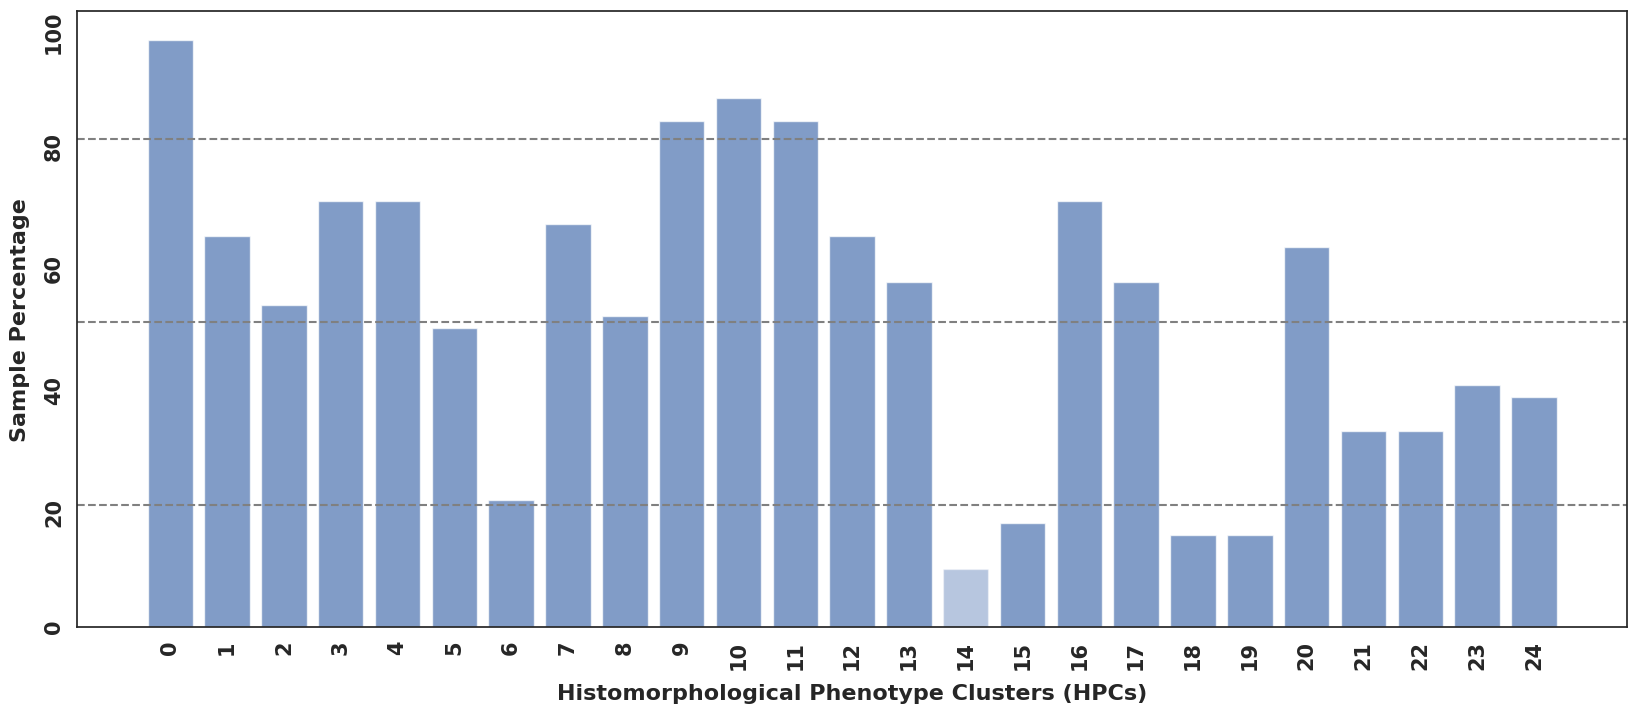

In [37]:
meta_folder = '250K'
# get additional dataset hpc frequency
csv_hpcs = "/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/acmeso/h224_w224_n3_zdim128/{}/adatas/acmeso_he_complete_leiden_2p0__fold4.csv".format(meta_folder)
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0)
resolution     = 2.0
fold_number    = 4
groupby        = 'leiden_%s' % resolution
matching_field = 'slides'
meta_field     = 'labels' #temporary
additional_df = pd.read_csv(csv_hpcs)
leiden_clusters = np.unique(additional_df[groupby].values.astype(int))
leiden_clusters = np.arange(0, max(leiden_clusters)+1, 1) #since it didn't have HPC9 in this cohort

frame_clusters, frame_samples = create_frames(additional_df, groupby, meta_field, diversity_key=matching_field, reduction=2);
_, df_all, _, _ = prepare_set_classes(additional_df, matching_field, meta_field, groupby, leiden_clusters, type_='clr', min_tiles=1, use_conn=False, use_ratio=False, top_variance_feat=99, keep_features=None, return_tiles=False);
inversed_df = pd.DataFrame(clr_inv(df_all[leiden_clusters]), columns=leiden_clusters.astype(str))


sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(20,8))
hpc_df = inversed_df.copy()*100
hpc_df = hpc_df > 1
hpc_df_percentages = hpc_df.astype(int).sum(axis=0)/hpc_df.shape[0]*100




ax.bar(hpc_df_percentages.index, hpc_df_percentages.values, alpha=0.7, align='center')
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
ax.axhline(80, color='gray', linestyle='--')
ax.axhline(50, color='gray', linestyle='--')
# ax.axhline(30, color='gray', linestyle='--')
ax.axhline(20, color='gray', linestyle='--')

# adding more tickes labels to x axis.
x_labels = [annotations.iloc[int(i)]['Summary']+ " - ("+i+")" for i in hpc_df_percentages.index]
x_labels = hpc_df_percentages.index.astype(str)
ax.set_xticks(hpc_df_percentages.index)
ax.set_xticklabels(x_labels, rotation=90, fontsize=15, fontweight='bold')
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=15, fontweight='bold', rotation=90)
ax.set_ylabel('Sample Percentage', fontsize=16, fontweight='bold', labelpad=10)

ax.set_xlabel('Histomorphological Phenotype Clusters (HPCs)', fontsize=16, fontweight='bold', labelpad=10)
ax.set_ylabel('Sample Percentage', fontsize=16, fontweight='bold', labelpad=10)
for i, (v, bar) in enumerate(zip(hpc_df_percentages.values, ax.patches)):
    # if v == hpc_df_percentages.max():
    #     bar.set_alpha(1)
    if v<15:
        bar.set_alpha(0.4)
print(hpc_df.sum().max(), 'HPC:', hpc_df.sum().idxmax())
print(hpc_df.sum().min(), 'HPC:', hpc_df.sum().idxmin())

In [6]:
from lifelines.plotting import add_at_risk_counts

def plot_KM_high_low(high_risk_df, low_risk_df, ax_title, ax, event_ind_field, event_data_field, max_months=None):
    

    fontsize_title  = 18
    fontsize_labels = 15
    fontsize_ticks  = 15
    fontsize_legend = 15
    l_markerscale   = 8
    l_box_w         = 3
    


    kmf_l = KaplanMeierFitter(label='Low-Risk')
    kmf_l.fit(low_risk_df[event_data_field].astype(float),  event_observed=low_risk_df[event_ind_field].astype(float))
    kmf_h = KaplanMeierFitter(label='High-Risk')
    kmf_h.fit(high_risk_df[event_data_field].astype(float), event_observed=high_risk_df[event_ind_field].astype(float))

    kmf_l.plot_survival_function(show_censors=True, ci_show=True, ax=ax)
    kmf_h.plot_survival_function(show_censors=True, ci_show=True, ax=ax)
    
    logrank_test_res = logrank_test(high_risk_df[event_data_field], low_risk_df[event_data_field], 
                        event_observed_A=high_risk_df[event_ind_field], 
                        event_observed_B=low_risk_df[event_ind_field])
    ax_title += '\n (P-Value: %.2E )' % (Decimal(logrank_test_res.p_value))

    ax.set_ylim([0.0,1.10])
    ax.patch.set_linewidth(1)
    if max_months is not None:
        ax.set_xlim([0.0, max_months])
    
    for ticks in [ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()]:
        for tick in ticks:
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label1.set_fontweight('bold')

    
    ax.set_title(ax_title, fontsize=fontsize_title, fontweight='bold', y=1.02)

    ax.set_xlabel('Time (Days)',         fontsize=fontsize_labels)
    ax.set_ylabel('Survival Probability', fontsize=fontsize_labels)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)

    legend = ax.legend(loc='best', markerscale=l_markerscale, title='Risk Group', prop={'size': fontsize_legend})
    legend.get_title().set_fontsize(fontsize_legend)
    legend.get_frame().set_linewidth(l_box_w)
    for line in legend.get_lines():
        line.set_linewidth(l_markerscale)
    
    add_at_risk_counts(kmf_l, kmf_h, ax=ax, ypos= -0.8)
    plt.tight_layout()

In [7]:
file_path = 'cox_model.joblib'
import joblib
cph_loaded = joblib.load(file_path)

In [10]:
# leiden_resolutions = ['0p5','1p0', '2p0']
leiden_resolutions = ['2p0']
# meta_folder = '250K'
results = {}
# set the random seed for reproducibility
import random
from tqdm import tqdm
random.seed(42)
from lifelines.utils import k_fold_cross_validation
import numpy as np
pca_components = None  # Set to None if you don't want PCA
def bootstrap_validation(cph, df, duration_col, event_col, n_bootstrap=200):
    n = len(df)
    c_indices = []
    
    for i in tqdm(range(n_bootstrap)):
        # Bootstrap sample
        boot_idx = np.random.choice(n, size=n, replace=True)
        boot_df = df.iloc[boot_idx]
        
        # Out-of-bag samples for testing
        oob_idx = np.setdiff1d(np.arange(n), np.unique(boot_idx))
        # print(f"Bootstrap iteration {i+1}/{n_bootstrap}, OOB samples: {len(oob_idx)}")
        if len(oob_idx) < 5:  # Skip if too few OOB samples
            continue
            
        oob_df = df.iloc[oob_idx]
        
        # Fit and evaluate
        cph.fit(boot_df, duration_col=duration_col, event_col=event_col)
        risk_scores = -cph.predict_partial_hazard(oob_df)
        
        c_idx = concordance_index(oob_df[duration_col], 
                                 risk_scores, 
                                 oob_df[event_col])
        c_indices.append(c_idx)
    
    return c_indices

for meta_folder in ['250K', '750K']:
    results[meta_folder] = {}
    for leiden_res in leiden_resolutions:
        results[meta_folder][leiden_res] = {}
        for fold in range(4,5):
            results[meta_folder][leiden_res][fold] = {}
            hpcs = pd.read_csv('/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/acmeso/h224_w224_n3_zdim128/{}/adatas/acmeso_he_complete_leiden_{}__fold{}.csv'.format(meta_folder, leiden_res, fold))

            hpcs['key'] = hpcs['slides'].map(renamings2)
            hpcs = pd.merge(hpcs, clinical, how='left', left_on='key', right_on='pathologyID')
            hpcs.dropna(subset=['key'], inplace=True)

            cluster_counts = pd.crosstab(hpcs['key'], hpcs['leiden_{}'.format(leiden_res.replace('p', '.'))])
            X = cluster_counts.values
            X_rep = multiplicative_replacement(X)       
            clr_X = clr(X_rep)  
            clr_df = pd.DataFrame(clr_X, columns=cluster_counts.columns.tolist())
            clr_df['most_common_hpc'] = cluster_counts.idxmax(axis='columns')
            clr_df['key'] = cluster_counts.index.tolist()
            clr_df = pd.merge(clr_df, clinical, how='left', left_on='key', right_on='pathologyID')
            leiden_cols = list([x for x in clr_df.columns if str(x).isdigit()])
            

            # penalizer = 1
            # l1_ratio = .02
            for penalizer in [1]:
                for l1_ratio in [0.01]:
                    if meta_folder=='750K': cph = cph_loaded
                    else:cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
                    

                    # metadata 
                    metadata_cols = ['stage', 'treatment', 'type','AGE_AT_REGISTRATION', 'bas_worst_pain', 'pain_response', 'change_worst_pain', 'rtc', 'nomets_formatted', 'allocdose_formatted', 'GEND'] 
                    mif_cols = ['MeanAutoFLTumour', 'MeanBCL.2Tumour', 'MeanBCLXLTumour', 'MeanBIMTumour', 'MeanCKPANTumour', 'MeanDAPITumour', 'MeanMCL1Tumour', 'MeanNOXATumour']
                    metadata_cols += mif_cols
                    metadata_cols += ['tresp_formatted', 'oresp_formatted']
                    clr_df['stage'] = clr_df['stage_formatted'].astype('category').cat.codes
                    clr_df['treatment'] = clr_df['treatment_formatted'].astype('category').cat.codes
                    clr_df['type'] = clr_df['histo_formatted'].map({'Biphasic':1, 'Epithelioid':0, 'Sarcomatoid':1})
                    clr_df['pain_response'] = clr_df['worst_pain_response'].astype('category').cat.codes
                    clr_df['rtc'] = clr_df['rtCompleted'].astype('category').cat.codes
                    clr_df['nomets_formatted'] = clr_df['nomets_formatted'].astype('category').cat.codes
                    clr_df['allocdose_formatted'] = clr_df['allocdose_formatted'].astype('category').cat.codes
                    clr_df['oresp_formatted'] = clr_df['oresp_formatted'].map({'CR': 4, 'PR': 3, 'SD': 2, 'PD': 1, 'Unevaluable': 0, None: 0})
                    clr_df['tresp_formatted'] = clr_df['tresp_formatted'].map({'CR': 4, 'PR': 3, 'SD': 2, 'PD': 1, 'Unevaluable': 0, None: 0})
                    clr_df['GEND'] = clr_df['GEND'].astype('category').cat.codes

                    clr_df.dropna(subset=['os_days', 'os_status', 'type'], inplace=True)
                    clr_df.fillna(0, inplace=True)

                    # cols = ['os_days', 'os_status'] + leiden_cols + metadata_cols
                    cols = ['os_days', 'os_status'] + leiden_cols
                    train_df = clr_df[cols]
                    # reset the index from 0
                    train_df.reset_index(drop=True, inplace=True)
            
                    print('number of slides:', train_df.shape[0], '| number of variants:', train_df.shape[1]-2, '| resolution:', leiden_res, '| penalizer:', penalizer, '| l1_ratio:', l1_ratio, 'meta_folder:', meta_folder)

                    # dimensionality reduction with PCA
                    if pca_components is not None:
                        from sklearn.decomposition import PCA
                        pca = PCA(n_components=pca_components)
                        pca_result = pca.fit_transform(train_df[leiden_cols])
                        pca_df = pd.DataFrame(pca_result, columns=[f'pca_{i+1}' for i in range(pca_result.shape[1])])
                        pca_df['os_days'] = train_df['os_days']
                        pca_df['os_status'] = train_df['os_status']
                        train_df = pca_df

                    # if meta_folder !='750k': 
                    cph.fit(train_df, duration_col='os_days', event_col='os_status', robust=True)
                    train_cindex = concordance_index(train_df['os_days'], -cph.predict_partial_hazard(train_df), train_df['os_status'])
                    print(f"Train C-Index: {train_cindex:.2f}")
                    # c_index_scores = [cph.concordance_index_]
                    results[meta_folder][leiden_res][fold]['train_c_index'] = train_cindex
                    results[meta_folder][leiden_res][fold]['cph'] = cph
                    results[meta_folder][leiden_res][fold]['cph_summary'] = cph.summary
                    results[meta_folder][leiden_res][fold]['clr_df'] = clr_df
                    results[meta_folder][leiden_res][fold]['cluster_counts'] = cluster_counts
                    display(cph.summary[cph.summary['p'] < 0.05])
                    # c_index_scores = k_fold_cross_validation(
                    #     cph,
                    #     df=train_df,
                    #     duration_col="os_days",
                    #     event_col="os_status",
                    #     k=5,
                    #     scoring_method="concordance_index"
                    # # )
                    # c_index_scores = bootstrap_validation(cph, train_df, 'os_days', 'os_status', n_bootstrap=200)
                    # print(f"Validation C-index:{np.mean(c_index_scores):.2f} ± {np.std(c_index_scores):.2f}")
                    # results[meta_folder][leiden_res][fold]['val_c_index_scores'] = c_index_scores
                    print("------"*50)
                    del cph



number of slides: 49 | number of variants: 25 | resolution: 2p0 | penalizer: 1 | l1_ratio: 0.01 meta_folder: 250K
Train C-Index: 0.76


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
7,0.093040,1.097505,0.031521,0.031259,0.154821,1.031753,1.167449,0.0,2.951637,0.003161,8.305427
10,-0.080673,0.922495,0.036690,-0.152584,-0.008762,0.858487,0.991276,0.0,-2.198781,0.027894,5.163927
11,0.105869,1.111676,0.032335,0.042492,0.169245,1.043408,1.184410,0.0,3.274067,0.001060,9.881563
12,0.073954,1.076757,0.021894,0.031043,0.116865,1.031530,1.123968,0.0,3.377878,0.000730,10.418879
17,0.106542,1.112425,0.041917,0.024385,0.188699,1.024685,1.207677,0.0,2.541714,0.011031,6.502287
20,-0.116515,0.890017,0.034696,-0.184519,-0.048511,0.831504,0.952647,0.0,-3.358132,0.000785,10.315549
24,-0.103227,0.901922,0.043847,-0.189165,-0.017290,0.827650,0.982859,0.0,-2.354283,0.018558,5.751779


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
number of slides: 49 | number of variants: 47 | resolution: 2p0 | penalizer: 1 | l1_ratio: 0.01 meta_folder: 750K
Train C-Index: 0.75


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
4,-0.036557,0.964103,0.017552,-0.070959,-0.002156,0.931500,0.997846,0.0,-2.082807,0.037269,4.745887
6,0.091866,1.096218,0.034653,0.023947,0.159785,1.024236,1.173259,0.0,2.651019,0.008025,6.961294
9,-0.058207,0.943455,0.028297,-0.113668,-0.002745,0.892555,0.997258,0.0,-2.056985,0.039688,4.655167
18,0.061707,1.063651,0.027087,0.008617,0.114797,1.008655,1.121646,0.0,2.278104,0.022720,5.459868
27,-0.058968,0.942737,0.029923,-0.117615,-0.000321,0.889038,0.999679,0.0,-1.970685,0.048760,4.358160
39,-0.068355,0.933929,0.030513,-0.128159,-0.008551,0.879714,0.991486,0.0,-2.240191,0.025079,5.317403


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Death clusters:  [17 11 7 12]
Alive clusters:  [20 24 10]


/tmp/ipykernel_2996522/331065309.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(results_df['hpc'])


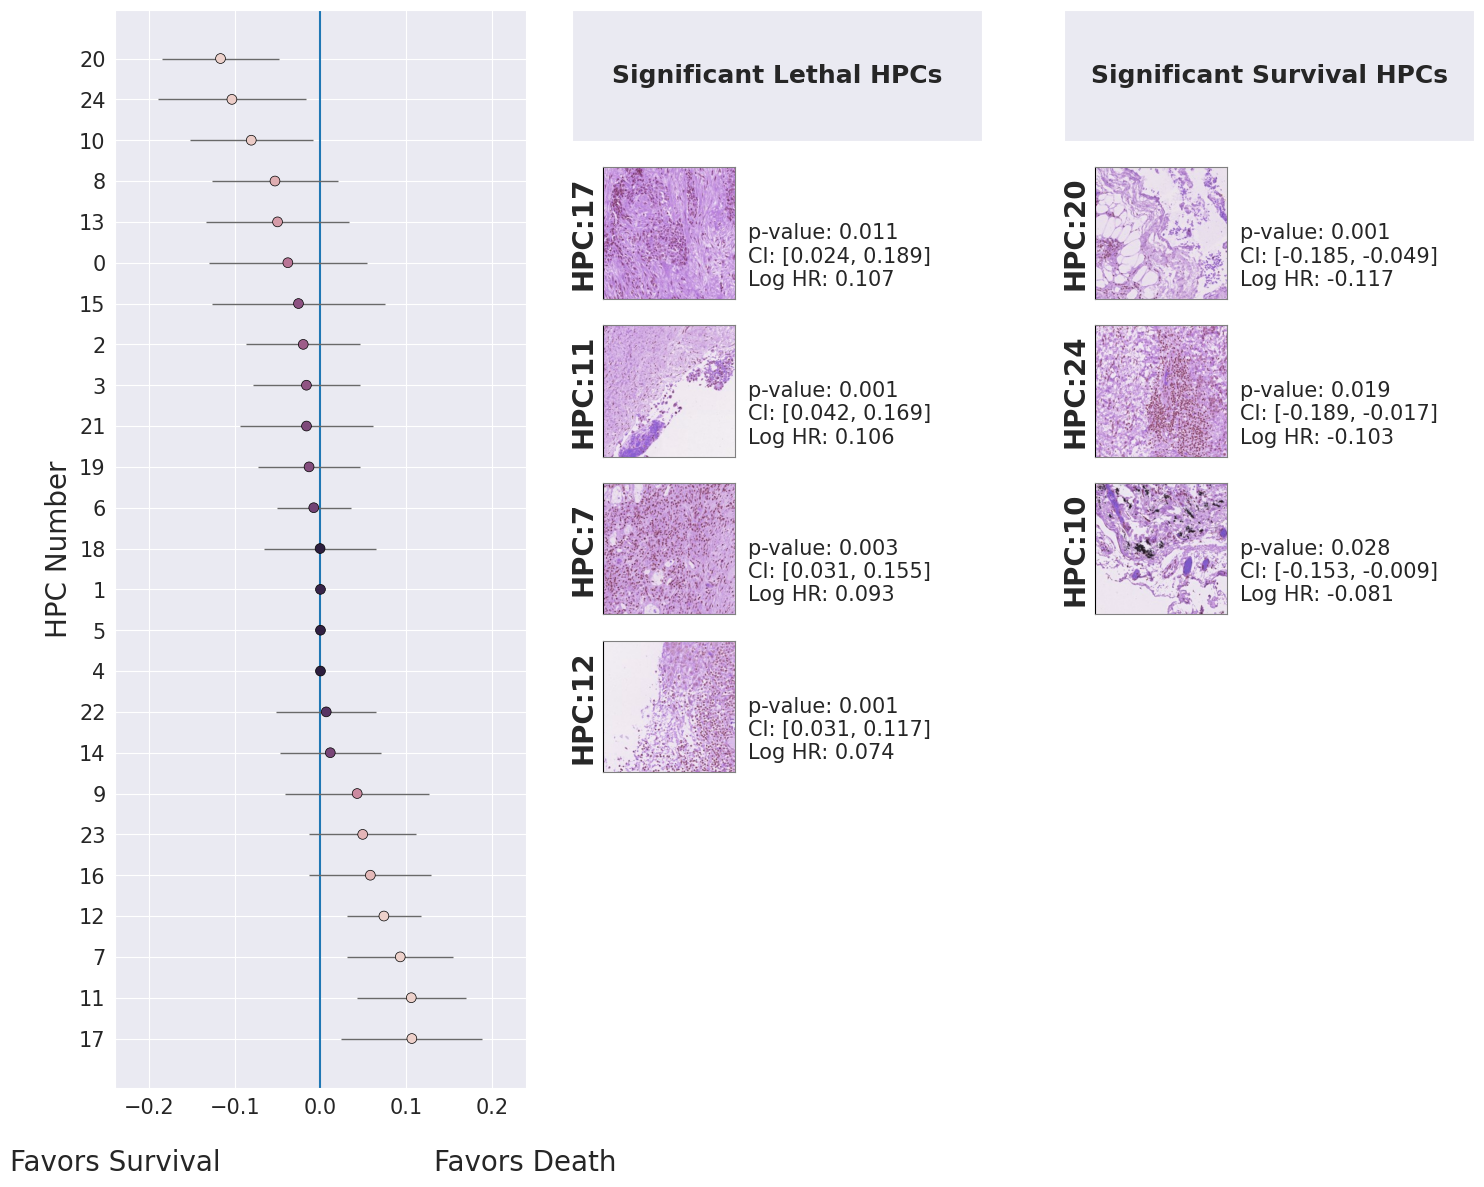

In [11]:
dataset = 'acmeso'
groupby = 'leiden_2.0'
meta_folder = '250K'
fold = 4


model = results[meta_folder]['2p0'][fold]['cph']

results_df = model.summary
# results_df = results[meta_folder]['2p0'][fold]['cph_summary']
results_df['hpc'] = results_df.index
results_df = results_df.sort_values(by='coef', ascending=False).reset_index(drop=True)



significance = 0.05
results_df_signfcnt = results_df[results_df['p'] < significance]
death_clusters = results_df_signfcnt[results_df_signfcnt['coef'] > 0].sort_values(by='coef', ascending=False)
alive_clusters = results_df_signfcnt[results_df_signfcnt['coef'] < 0].sort_values(by='coef', ascending=True)
print('Death clusters: ', death_clusters['hpc'].values)
print('Alive clusters: ', alive_clusters['hpc'].values)




h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete.h5'.format(main_path, dataset, dataset)
hpcs = pd.read_csv('/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/acmeso/h224_w224_n3_zdim128/{}/adatas/acmeso_he_complete_leiden_{}__fold{}.csv'.format(meta_folder, groupby.split('_')[-1].replace('.', 'p'), fold))




# export needed tiles
im_list_dict = dict()
for class_ in ['death', 'alive']:
    im_list = []
    if class_ == 'death': cluster_set = death_clusters.hpc.astype('str')
    elif class_ == 'alive': cluster_set = alive_clusters.hpc.astype('str')
    for cluster_number in cluster_set:
        indexes= hpcs[hpcs[groupby] == int(cluster_number)][['indexes','original_set']]
        index_, set_ = indexes.sample(n=1).values[0]
        if set_ == 'valid': set_address = 'validation' 
        else: set_address = set_
        h5_image_path = h5_complete_path.split('results/')[0] + 'datasets/{}/he/patches_h224_w224/hdf5_{}_he_{}.h5'.format(dataset, dataset, set_address)
        h5_image = h5py.File(h5_image_path, 'r')
        im_list.append((h5_image['{}_img'.format(set_)][int(index_)], cluster_number))
        h5_image.close()
    im_list_dict[class_] = im_list


import textwrap
sns.set_style("darkgrid")

#  Forest Plot
center = 0.0
effect_measure = results_df['coef'].values.astype(str).astype(float)
lower = results_df['coef lower 95%'].values
upper = results_df['coef upper 95%'].values
diff_upper = upper - effect_measure
diff_lower = effect_measure - lower

ncol, nrow = 3, 7
fig = plt.figure(figsize=(6*ncol, 2*nrow))
gs = fig.add_gridspec(nrow, ncol)
ax1 = fig.add_subplot(gs[:, 0])


fontsize = 20
plot = sns.scatterplot(data=results_df, x='coef', y=results_df.index, hue='p', sizes=(20, 200), legend=False, zorder=3, edgecolor='black', linewidth=0.5, s=50, ax=ax1)
plot.set_yticklabels(results_df['hpc'])
plot.set_yticks(results_df.index)
for tick in plot.yaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
for tick in plot.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
plot.axvline(center, zorder=1)
plot.errorbar(effect_measure, results_df.index, xerr=[diff_upper, diff_lower], marker='None',zorder=2, ecolor='dimgrey', elinewidth=1, linewidth=0)

plot.set_xlabel('', fontsize=fontsize)
plot.set_ylabel('HPC Number', fontsize=fontsize)
max_value = max(abs(max(upper)), abs(min(lower)))
plot.set_xlim([-max_value-.05, max_value+.05])
plot.text(0.0, -.07, textwrap.fill('Favors Survival',30), horizontalalignment='center', verticalalignment='center', transform=plot.transAxes, fontsize=fontsize)
plot.text(1.0, -.07, textwrap.fill('Favors Death',30), horizontalalignment='center', verticalalignment='center', transform=plot.transAxes, fontsize=fontsize);
################################################################################################################################ 



# Legends
if meta_folder=='750K': annot_flag = True
else: annot_flag = False
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()
for class_ in ['death', 'alive']:
    im_list = im_list_dict[class_]
    if class_=='death': 
        i, j = 0, 1
        title = 'Significant Lethal HPCs'
    else: 
        i, j = 0, 2
        title = 'Significant Survival HPCs'
    ax = fig.add_subplot(gs[i,j])
    ax.set(xticks=[], yticks=[])
    ax.text(0.5, 0.5, textwrap.fill(title, 30), fontsize=18, ha='center', va='center', weight='bold')
    pos = ax.get_position()
    ax.set_position([pos.x0-.02, pos.y0, pos.width, pos.height])
    i+=1

    for (image, cluster_number) in im_list:
        ax = fig.add_subplot(gs[i, j])
        if image is not None:
            ax.imshow(image)
        else:
            cluster_number = cluster_number.split('_')[0]

        cluster_number = int(cluster_number)
        ax.set(xticks=[], yticks=[])
        i += 1

        ax.set_ylabel('HPC:{}'.format(cluster_number), fontdict=dict(weight='bold', size=20))
        ax.set_axis_on()
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('gray')
        ax.spines['top'].set_color('gray')
        ax.spines['bottom'].set_color('gray')
        pos = ax.get_position()
        ax.set_position([pos.x0-.08, pos.y0, pos.width, pos.height])

        p_value = results_df[results_df['hpc']==cluster_number]['p'].values[0]
        log_HR = results_df[results_df['hpc']==cluster_number]['coef'].values[0]
        CI = [results_df[results_df['hpc']==cluster_number]['coef lower 95%'].values[0], results_df[results_df['hpc']==cluster_number]['coef upper 95%'].values[0]]
        if annot_flag: annotation_text = textwrap.fill(annotations[annotations['HPC']==cluster_number]['Summary'].values[0], 30)
        else: annotation_text = ''
        label_text = annotation_text + '\n \n'+ 'p-value: {}'.format(np.round(p_value, 3)) + '\n' + 'CI: [{}, {}]'.format(np.round(CI[0], 3), np.round(CI[1], 3)) + '\n' + 'Log HR: {}'.format(np.round(log_HR, 3))
        
        ax.text(1.1, .5, label_text,
                transform=ax.transAxes,
                horizontalalignment="left", verticalalignment="center", size="15", )


Death clusters:  [17 11 7 12]
Alive clusters:  [20 24 10]


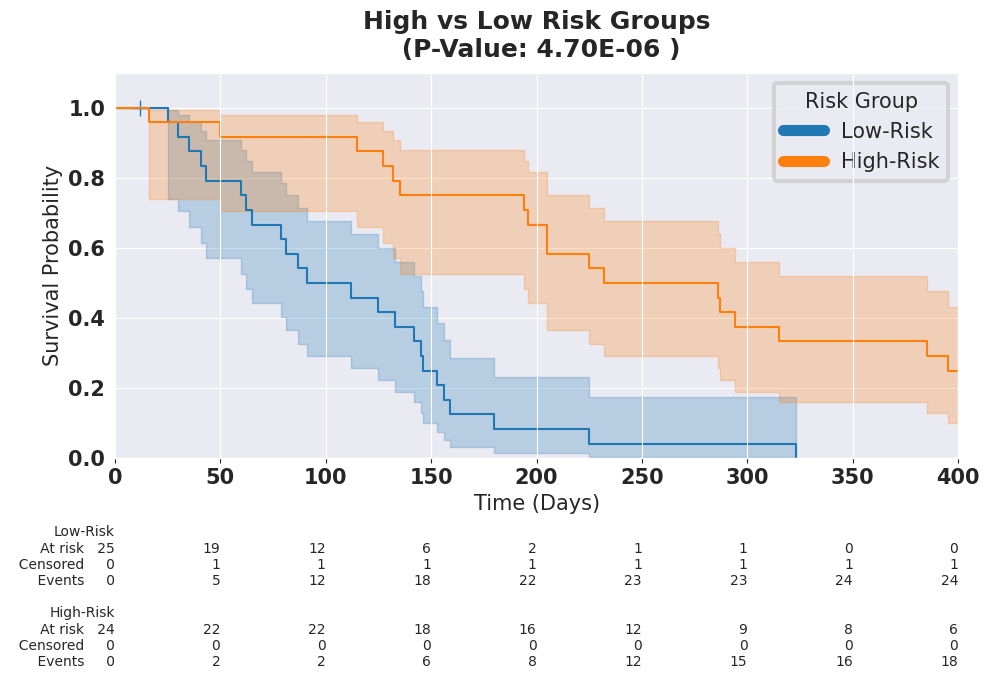

In [12]:
# meta_folder = '250K'
# fold = 4


model = results[meta_folder]['2p0'][fold]['cph']
data = results[meta_folder]['2p0'][fold]['clr_df']
leiden_cols = list([x for x in data.columns if str(x).isdigit()])
results_df = model.summary
results_df['hpc'] = results_df.index
results_df = results_df.sort_values(by='coef', ascending=False).reset_index(drop=True)



significance = 0.05
results_df_signfcnt = results_df[results_df['p'] < significance]
death_clusters = results_df_signfcnt[results_df_signfcnt['coef'] > 0].sort_values(by='coef', ascending=False)
alive_clusters = results_df_signfcnt[results_df_signfcnt['coef'] < 0].sort_values(by='coef', ascending=True)
print('Death clusters: ', death_clusters['hpc'].values)
print('Alive clusters: ', alive_clusters['hpc'].values)





data['partial_hazard'] = -model.predict_partial_hazard(data[leiden_cols])
high_risk = data[data['partial_hazard'] > data['partial_hazard'].median()]
low_risk = data[data['partial_hazard'] <= data['partial_hazard'].median()]
ax = plt.figure(figsize=(10, 7)).add_subplot(111)
plot_KM_high_low(high_risk, low_risk, 'High vs Low Risk Groups', ax, 'os_status', 'os_days', max_months=400)
plt.tight_layout()


Number of vars: 74
Found 8 significant correlations after FDR correction


,Clinical,HPC,Correlation,P-value,FDR_P_value
450,MeanDAPITumour,0,0.665125,3.399810e-07,0.000178
55,type,5,0.568925,3.011331e-05,0.007905
405,MeanBIMTumour,5,-0.544750,7.532208e-05,0.013181
401,MeanBIMTumour,1,-0.532724,1.158423e-04,0.015204
354,MeanBCL.2Tumour,4,-0.509135,2.574880e-04,0.027036
480,MeanMCL1Tumour,5,-0.502775,3.162465e-04,0.027672
455,MeanDAPITumour,5,-0.488321,4.972203e-04,0.037292
413,MeanBIMTumour,13,0.475023,7.410697e-04,0.048633


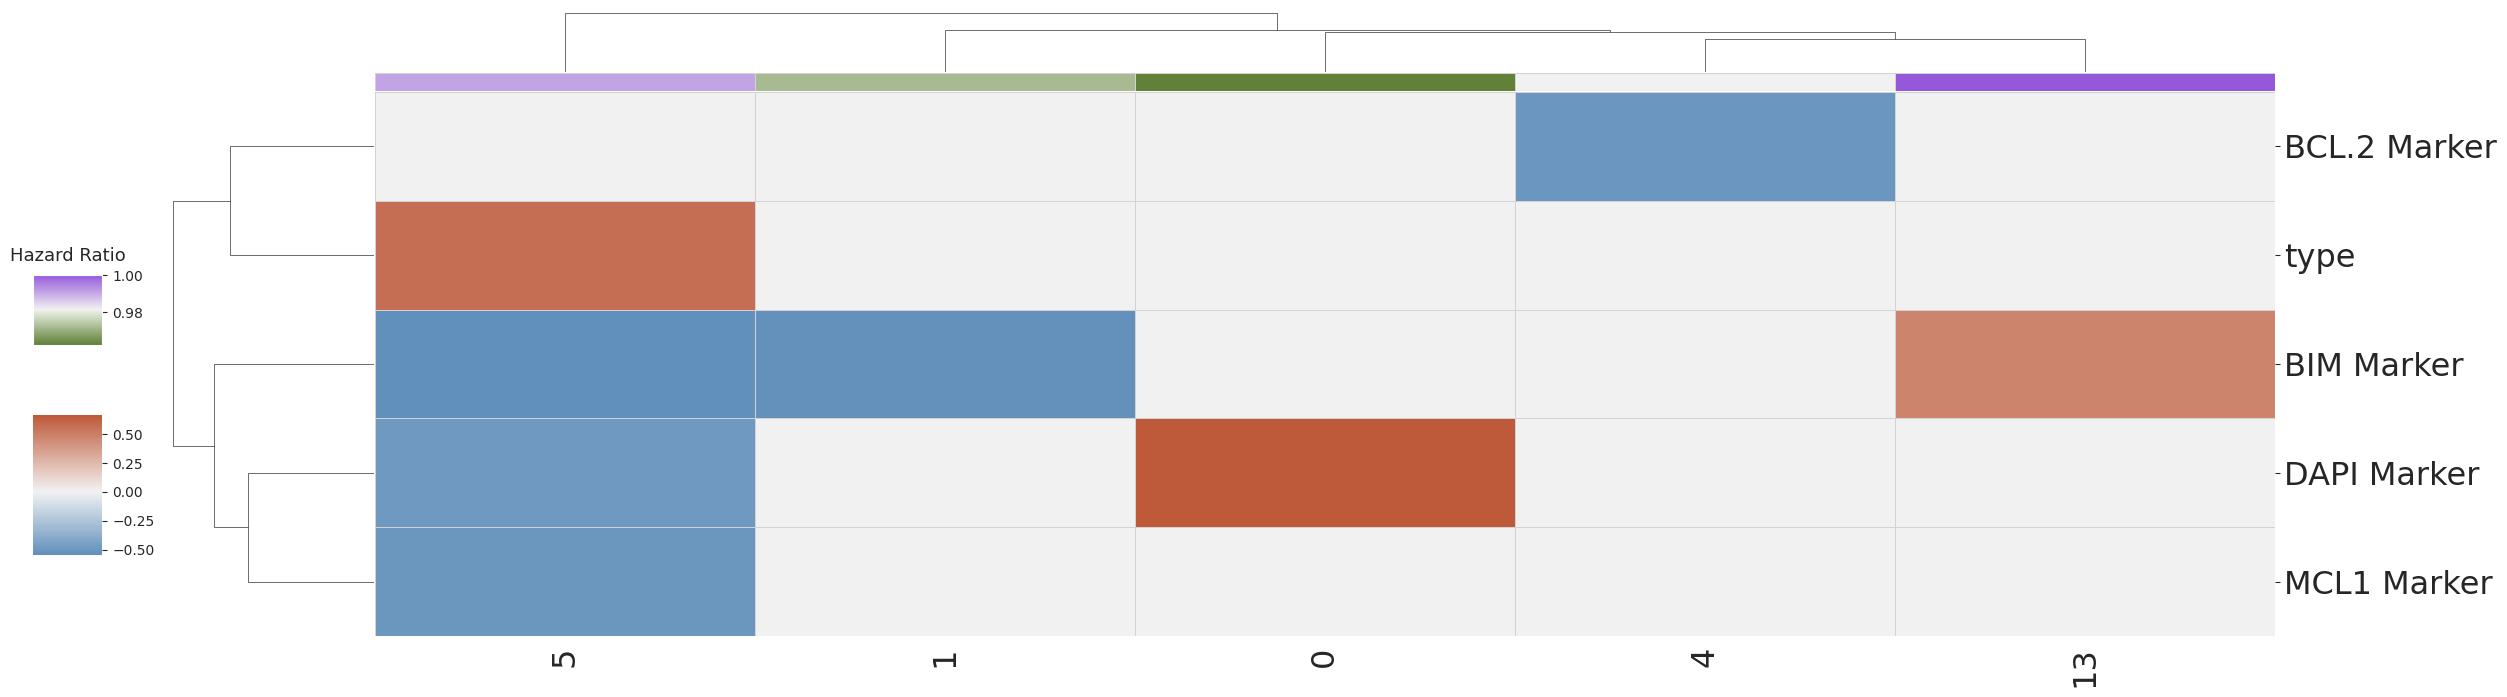

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from matplotlib.patches import Patch

def analyze_correlations(result_df, cluster_cols, metadata_cols, method='pearson'):
    results = []
    for meta_col in metadata_cols:
        if result_df[meta_col].dtype in [np.float64, np.int64, np.int8]:  # Numeric columns only: the expression values
            for cluster in cluster_cols:
                if method == 'pearson':
                    corr, p_value = stats.pearsonr(result_df[cluster], result_df[meta_col])
                else:
                    corr, p_value = stats.spearmanr(result_df[cluster], result_df[meta_col])
                results.append({
                    'Clinical': meta_col,
                    'HPC': cluster,
                    'Correlation': corr,
                    'P-value': p_value
                })
    
    corr_results = pd.DataFrame(results)
    if len(corr_results) > 0:
        _, corr_results['FDR_P_value'], _, _ = multipletests(
            corr_results['P-value'], alpha=0.05, method='fdr_bh')
    return corr_results

meta_folder = '250K'
fold = 4
data = results[meta_folder]['2p0'][fold]['clr_df'].copy()

# adding (merging) the mif data
data = pd.merge(data, mif_data, on='TRIALNO', how='inner')



model = results[meta_folder]['2p0'][fold]['cph']
print('Number of vars:', data.shape[1])
leiden_cols = list([x for x in data.columns if str(x).isdigit()])
clinical_cols = ['stage', 'treatment', 'type','AGE_AT_REGISTRATION', 'bas_worst_pain', 'pain_response', 'change_worst_pain', 'rtc', 'nomets_formatted', 'allocdose_formatted', 'oresp_formatted', 'tresp_formatted', 'GEND' ] 
mif_cols = ['MeanAutoFLTumour', 'MeanBCL.2Tumour', 'MeanBCLXLTumour', 'MeanBIMTumour', 'MeanCKPANTumour', 'MeanDAPITumour', 'MeanMCL1Tumour', 'MeanNOXATumour']
metadata_cols = clinical_cols + mif_cols
# metadata_cols = mif_cols

correlation_results = analyze_correlations(data, leiden_cols, metadata_cols, method='Spearman')
significant_corrs = correlation_results[correlation_results['FDR_P_value'] < 0.05].sort_values('FDR_P_value')
print(f"Found {len(significant_corrs)} significant correlations after FDR correction")
display(significant_corrs)

if len(significant_corrs) > 0:
    pivot = significant_corrs.pivot(index='Clinical', columns='HPC', values='Correlation')
    # pivot = correlation_results.pivot(index='Clinical', columns='HPC', values='Correlation')

    col_color = pd.DataFrame(pivot.columns.tolist(), columns=['HPC'])
    col_color['hr_scores'] = model.summary['exp(coef)']
    # nc = dict(zip(col_color['tissue_type'].unique(), sns.color_palette("colorblind")))
    hr = dict(zip(col_color['hr_scores'].to_list(), sns.diverging_palette(110, -80, n= len(col_color.hr_scores))))
    # col_color['color'] = col_color['tissue_type'].map(nc)
    col_color['hr_color'] = col_color['hr_scores'].map(hr)
    # handles = [Patch(facecolor=nc[name]) for name in nc]
    
    cl_map = sns.clustermap(pivot.fillna(0), cmap=sns.diverging_palette(245,22, as_cmap=True), center=0, figsize=(23,7), linecolor='lightgray', linewidths=0.5, cbar_pos=(-.05, .2, .03, .2), dendrogram_ratio=(.1,.1), col_colors=col_color['hr_color'].tolist())
    annot_df = pd.read_csv("/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/files/meso_annotations_750K.csv")
    y_labels = [y.get_text().replace('Mean', '').replace('Tumour',' Marker').replace('_', ' ') for y in cl_map.ax_heatmap.get_yticklabels()]
    # y_labels = y.get_text()
    cl_map.ax_heatmap.set_yticklabels(y_labels, rotation=0, fontsize=23)
    if meta_folder == '750K':
        cl_map.ax_heatmap.set_xticklabels([annot_df[annot_df['HPC']==int(x.get_text())]['Summary'].values[0] + f"({x.get_text()}) " for x in cl_map.ax_heatmap.get_xticklabels()], fontsize=23, rotation=90)
    cl_map.ax_heatmap.set_xticklabels(cl_map.ax_heatmap.get_xticklabels(), fontsize=23, rotation=90)
    cl_map.ax_heatmap.set_xlabel('')
    cl_map.ax_heatmap.set_ylabel('')



    # m = plt.cm.ScalarMappable(cmap=sns.diverging_palette(110, -80, as_cmap=True), norm=plt.Normalize(vmin=-0.09, vmax=0.05))
    m = plt.cm.ScalarMappable(cmap=sns.diverging_palette(110, -80, as_cmap=True), norm=plt.Normalize(vmin=col_color.hr_scores.min(), vmax=col_color.hr_scores.max()))
    cbar_ax = cl_map.fig.add_axes((-.05, .5, .03, .1))
    cbar_ax.set_title('Hazard Ratio', fontsize=13, pad=10)
    cbar2 = cl_map.fig.colorbar(m, cax=cbar_ax)



In [31]:
col_color.hr_scores.min(), col_color.hr_scores.max()

(0.9434550891318079, 1.09621814589188)

In [32]:
col_color.sort_values(by='hr_scores', ascending=False)

,HPC,hr_scores,hr_color
6,16,1.096218,"(0.9474351487481705, 0.9461957437373959, 0.949..."
2,7,1.051263,"(0.5613145622727181, 0.65198620653227, 0.45000..."
11,31,1.038721,"(0.6423385917646651, 0.44392628494973657, 0.87..."
12,44,1.013113,"(0.582400199792006, 0.3451696764137159, 0.8572..."
8,21,1.000001,"(0.8264295067677458, 0.7472409690722265, 0.919..."
7,19,1.000000,"(0.886367898740405, 0.8459975776082472, 0.9348..."
3,8,0.999999,"(0.6587460385745061, 0.7310458627152937, 0.572..."
5,15,0.987053,"(0.8406339165494734, 0.8786366992948356, 0.800..."
1,1,0.985248,"(0.4703706232852345, 0.5781907882424989, 0.335..."
10,26,0.973673,"(0.7022769837373244, 0.5426828934857574, 0.887..."


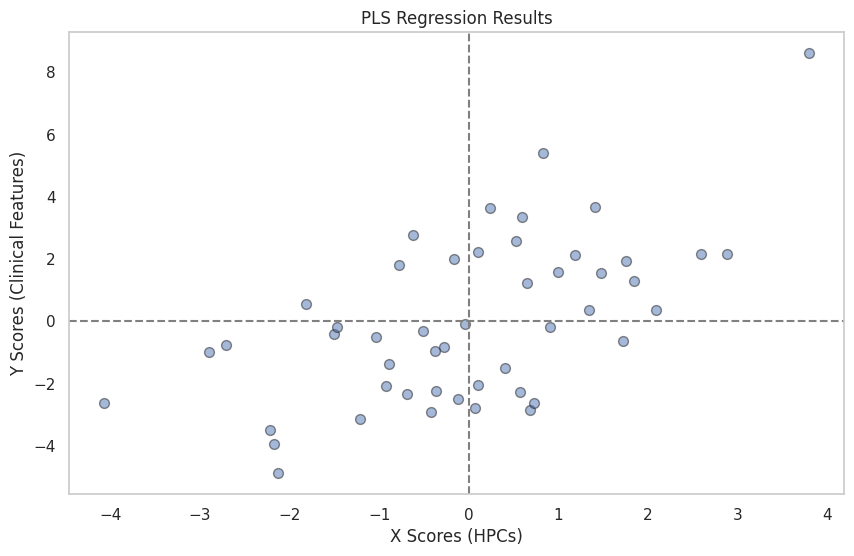

In [183]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components=2)
pls.fit(clr_df[leiden_cols], clr_df[metadata_cols])
X_scores, Y_scores = pls.transform(clr_df[leiden_cols], clr_df[metadata_cols])  
plt.figure(figsize=(10, 6))
plt.scatter(X_scores[:, 1], Y_scores[:, 1], alpha=0.5, edgecolors='k', s=50)
plt.title('PLS Regression Results')
plt.xlabel('X Scores (HPCs)')
plt.ylabel('Y Scores (Clinical Features)')
plt.grid()
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.show()


In [145]:
data['tresp_formatted'].value_counts()

tresp_formatted
2.0    14
3.0     9
1.0     7
Name: count, dtype: int64

/tmp/ipykernel_2416532/3109691077.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticks(), fontsize=15)


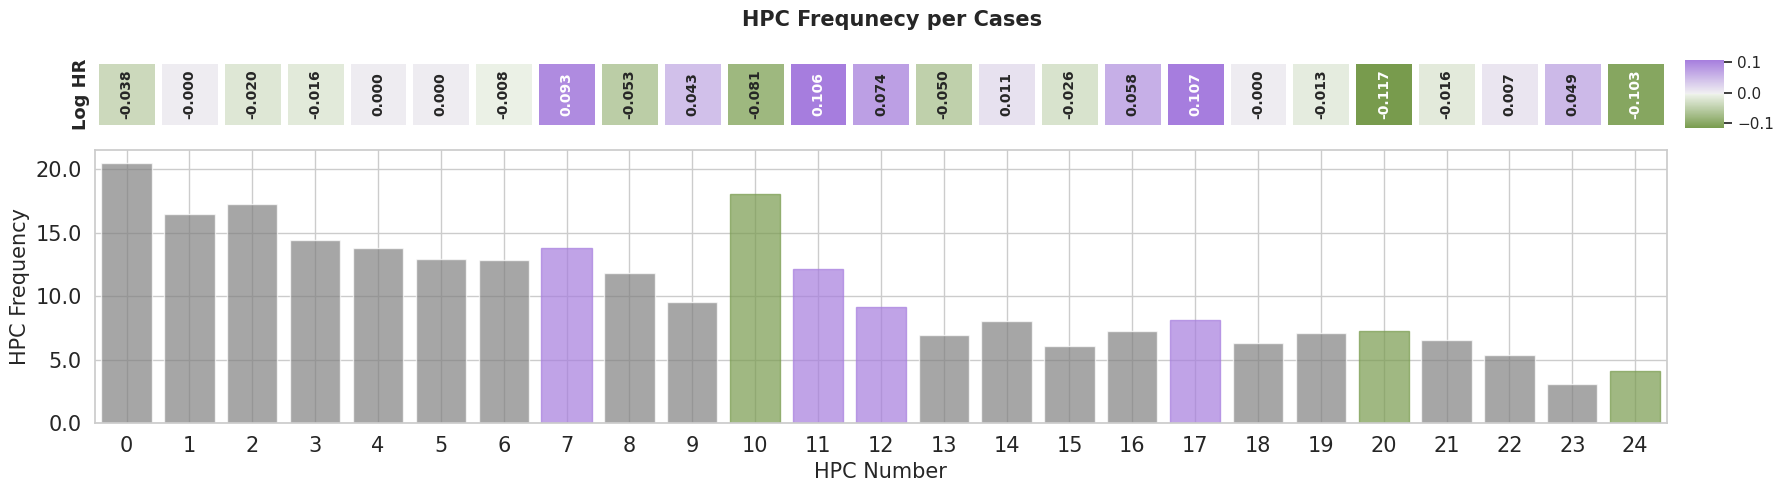

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.stats.composition import clr_inv
sns.set_theme(style="whitegrid")

dataset = 'acmeso'
groupby = 'leiden_2.0'
meta_folder = '250K'
fold = 4

data = results[meta_folder]['2p0'][fold]['cluster_counts']
leiden_cols = list([x for x in data.columns if str(x).isdigit()])
# df = data[leiden_cols].copy()
# inversed_df = pd.DataFrame(clr_inv(df[leiden_cols]), columns=leiden_cols)


model = results[meta_folder]['2p0'][fold]['cph']
results_df = model.summary
results_df['hpc'] = results_df.index
results_df = results_df.sort_values(by='coef', ascending=False).reset_index(drop=True)
log_hr_hpcs = model.summary.coef.values
p_values = model.summary.p


fig, ((ax1, cbar_ax), (ax2, dummy_ax)) = plt.subplots(nrows=2, ncols=2, figsize=(18, 5), sharex='col',
                                                      gridspec_kw={'height_ratios': [1, 4], 'width_ratios': [40, 1]})

# add title
fig.suptitle('HPC Frequnecy per Cases', fontsize=15, fontweight='bold')
sns.heatmap(log_hr_hpcs.reshape(1,-1), cmap=sns.diverging_palette(110,-80, as_cmap=True, s=70, l=60), cbar=True, annot=True, fmt=".3f", annot_kws={"size": 10, 'rotation': 90, 'weight':'bold'}, cbar_ax=cbar_ax, xticklabels=False, linewidths=5, ax=ax1)

ax1.set_yticks([]);
ax1.set_ylabel('Log HR', fontsize=13, fontweight='bold')

x_tick_pos = [i + 0.5 for i in range(len(leiden_cols))]
ax2.bar(x_tick_pos, data.mean(axis=0), align='center', alpha=0.7, color='gray')
ax2.set_xticks(x_tick_pos)
mean_log_hr = log_hr_hpcs.mean()
for i, (log_hr, bar) in enumerate(zip(log_hr_hpcs, ax2.patches)):
    if p_values[i] < 0.05: 
        if log_hr < mean_log_hr: bar.set_color((0.470115900272216, 0.6097260077465355, 0.30236505678438585)) 
        elif log_hr >= mean_log_hr: bar.set_color((0.649668349443489, 0.4919529160772547, 0.8704938707582672)) 
    
ax2.set_xticklabels(leiden_cols,fontsize=15)
ax2.set_yticklabels(ax2.get_yticks(), fontsize=15)
ax2.set_xlabel('HPC Number', fontsize=15)
ax2.set_ylabel('HPC Frequency', fontsize=15)
dummy_ax.axis('off')

plt.tight_layout()
# plt.show()
# plt.savefig(os.path.join(figure_path, 'hpc_freq_epithelioid.jpg'), dpi=500, bbox_inches='tight')
# plt.savefig(os.path.join(figure_path, 'hpc_freq_sarc_bip.jpg'), dpi=500, bbox_inches='tight')

In [48]:
cph.check_assumptions(train_df, p_value_threshold=0.05)


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 49 total observations, 1 right-censored observations>
         test_name = proportional_hazard_test

---
         test_statistic      p  -log2(p)
0  km              0.11   0.74      0.43
   rank            0.10   0.75      0.41
1  km              2.43   0.12      3.07
   rank            2.51   0.11      3.14
2  km              2.74   0.10      3.35
   rank            2.71   0.10      3.33
3  km              0.01   0.91      0.14
   rank            0.02   0.88      0.18
4  km              0.48   0.49      1.03
   rank            0.52   0.47      1.09
5  km              2.23   0.14      2.89
   rank            2.28   0.13      2.93
6  km              1.26   0.26      1.94
   rank            1.25   0.26      1.93
7  km              0.06   0.80      0.32
   rank            0.06   0.81      0.30
8  km              0.03   0.86      0.22
   rank            0.04   0.85      0.24
9  km              3.14   0.08      3.71
   rank            3.04   0.08      3.62
10 km              0.45   0.50      0.99
   rank            0.47   0.49      1.03
11 km              1.64   0.20      2.32
   rank            1.59   0.21      2.27
12 km              0.00   0.98      0.03
   rank            0.00   0.98      0.03
13 km              0.02   0.89      0.17
   rank            0.01   0.91      0.13
14 km              2.31   0.13      2.96
   rank            2.29   0.13      2.94
15 km              0.08   0.78      0.35
   rank            0.07   0.79      0.34
16 km              0.01   0.92      0.11
   rank            0.00   0.94      0.08
17 km              0.50   0.48      1.07
   rank            0.48   0.49      1.03
18 km              0.10   0.76      0.40
   rank            0.08   0.78      0.36
19 km              0.27   0.60      0.73
   rank            0.26   0.61      0.71
20 km              0.57   0.45      1.15
   rank            0.56   0.45      1.14
21 km              1.40   0.24      2.08
   rank            1.36   0.24      2.04
22 km              2.24   0.13      2.89
   rank            2.16   0.14      2.82
23 km              2.70   0.10      3.32
   rank            2.68   0.10      3.30
24 km              0.35   0.56      0.85
   rank            0.34   0.56      0.84
25 km              0.07   0.80      0.33
   rank            0.06   0.81      0.30
26 km              1.95   0.16      2.62
   rank            1.94   0.16      2.61
27 km              0.60   0.44      1.19
   rank            0.60   0.44      1.19
28 km              0.32   0.57      0.81
   rank            0.35   0.55      0.86
29 km              0.29   0.59      0.76
   rank            0.27   0.60      0.73
30 km              9.44 <0.005      8.88
   rank            9.36 <0.005      8.81
31 km              8.75 <0.005      8.34
   rank            8.74 <0.005      8.33
32 km              6.97   0.01      6.92
   rank            7.11   0.01      7.03
33 km              0.00   0.97      0.05
   rank            0.00   0.96      0.06
34 km              2.63   0.10      3.26
   rank            2.58   0.11      3.21
35 km              2.12   0.15      2.78
   rank            2.20   0.14      2.85
36 km              0.21   0.65      0.63
   rank            0.20   0.66      0.61
37 km             24.31 <0.005     20.22
   rank           23.72 <0.005     19.77
38 km              0.64   0.43      1.23
   rank            0.59   0.44      1.18
39 km              0.15   0.70      0.51
   rank            0.17   0.68      0.55
40 km              2.30   0.13      2.95
   rank            2.26   0.13      2.92
41 km              0.00   0.94      0.08
   rank            0.00   0.97      0.05
42 km              0.60   0.44      1.18
   rank            0.65   0.42      1.26
43 km              0.24   0.62      0.68
   rank            0.25   0.62      0.69
44 km              1.36   0.24      2.04
   rank            1.38   0.24      



1. Variable '30' failed the non-proportional test: p-value is 0.0021.

   Advice 1: the functional form of the variable '30' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable '30' using pd.cut, and then specify it in `strata=['30', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable '31' failed the non-proportional test: p-value is 0.0031.

   Advice 1: the functional form of the variable '31' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning t

[]

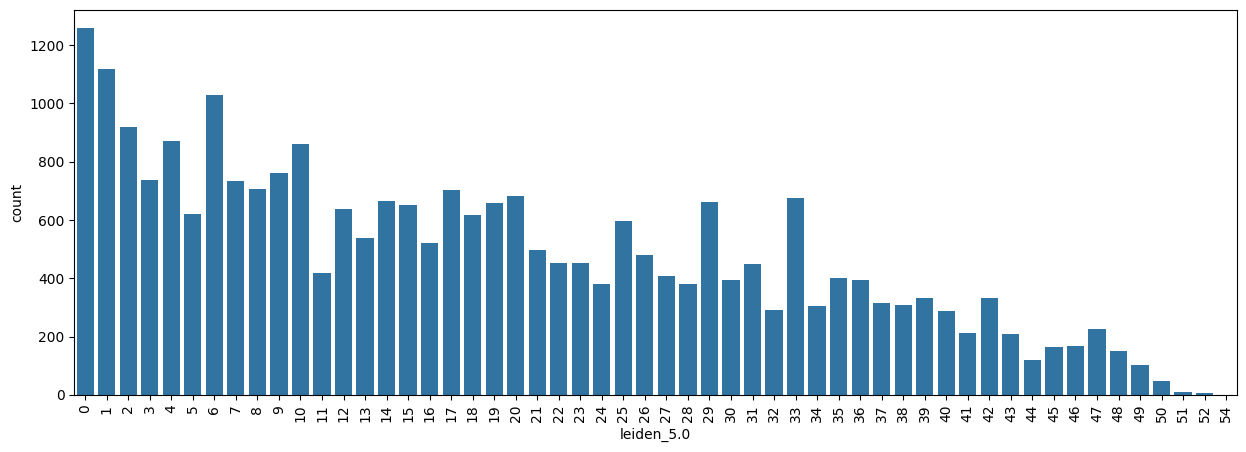

In [18]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
# sns.set(style="whitegrid")
temp = hpcs['leiden_5.0'].value_counts().reset_index()
sns.barplot(x='leiden_5.0', y='count', data=temp)
plt.xticks(rotation=90);

In [ ]:

clr_df

,0,1,2,3,4,5,6,7,8,9,...,rtCompleted,pathologyID,pathBlockID,pathBlockIDonBlock,pathmIFID,os_treatment,os_days,os_months,os_status_formatted,os_status
0,-1.274750,-1.274750,-1.274750,4.246711,3.553564,-1.274750,-1.274750,-1.274750,-1.274750,-1.274750,...,NaN,01695/17 02,29.0,1701695. 02,170169502,B,12.0,0.394251,Alive,0.0
1,-1.363858,-1.363858,5.256816,-1.363858,1.942630,-1.363858,-1.363858,3.552068,-1.363858,-1.363858,...,No,16.40778D,42.0,16.40778D,1640778D11,A,16.0,0.525667,Dead,1.0
2,4.877082,-1.312122,-1.312122,4.877082,3.673109,-1.312122,-1.312122,-1.312122,2.574497,4.366256,...,Yes,17HS00575Y A&B,6.0,17HS00575Y,17H5005754B,B,62.0,2.036961,Dead,1.0
3,2.736047,-1.422836,-2.592486,2.338364,1.755218,-2.592486,0.523074,-2.592486,2.405805,-0.729689,...,Yes,17HS02345J,26.0,17HS02345J,17HS02345JDPLE,A,81.0,2.661191,Dead,1.0
4,-0.844071,-0.844071,-0.844071,-0.844071,5.172087,-0.844071,4.478939,-0.844071,-0.844071,-0.844071,...,NaN,19H-005351,76.0,B19005351 (SP19-10133A1),B19005351,A,205.0,6.735113,Dead,1.0
5,2.217979,1.524832,-2.167859,4.442603,2.777595,2.217979,1.524832,-2.167859,0.831685,2.911127,...,Yes,A190026728,80.0,A19267281,A19267281,A,60.0,1.971253,Dead,1.0
6,-1.394774,-1.394774,-1.394774,3.104341,5.050251,-1.394774,-1.394774,-1.394774,2.411194,4.976143,...,Yes,"D,16.0012075.H A1",34.0,"D,16.0012075.H A1",D160012075HA1,A,1801.0,59.170431,Dead,1.0
7,1.643603,1.643603,-2.135062,2.742215,3.029897,-2.135062,1.643603,-2.135062,-2.135062,-2.135062,...,Yes,"D,16.0026763.M A1",17.0,"D,16.0026763.M A1",D160026763M,B,385.0,12.648871,Dead,1.0
8,2.151624,-2.514063,-2.514063,2.151624,2.637132,0.072183,2.269407,-2.514063,1.458477,-2.514063,...,NaN,"D,16.0028547.R A1",2.0,"D,16.0028547.R A1",D160028547RA1,A,87.0,2.858316,Dead,1.0
9,-2.366623,0.028169,-2.366623,2.107610,3.639087,1.819928,2.513075,0.721316,-2.366623,0.028169,...,NaN,"D,16.0084623.B A1",12.0,"D,16.0084623.B A1",D160084623B1,B,125.0,4.106776,Dead,1.0


In [95]:
clr_df.columns

Index([                    0,                     1,                     2,
                           3,                     4,                     5,
                           6,                     7,                     8,
                          10,                    11,                    12,
                          13,                    14,                    15,
                          16,                    17,                    18,
                          19,                    20,                    21,
                          22,                    23,                    24,
                          25,                    26,                    27,
                          28,                    29,                    30,
                          31,                    32,                    33,
                          34,                    35,                    36,
                          37,                    38,                    39,
            

model,lifelines.CoxPHFitter
duration col,'os_days'
event col,'os_status'
penalizer,1
l1 ratio,0.02
robust variance,True
baseline estimation,breslow
number of observations,49
number of events observed,48
partial log-likelihood,-130.70
time fit was run,2025-06-03 13:21:16 UTC


model,lifelines.CoxPHFitter
duration col,'os_days'
event col,'os_status'
penalizer,1
l1 ratio,0.02
robust variance,True
baseline estimation,breslow
number of observations,42
number of events observed,42
partial log-likelihood,-112.31
time fit was run,2025-05-28 14:37:51 UTC


<Axes: xlabel='log(HR) (95% CI)'>

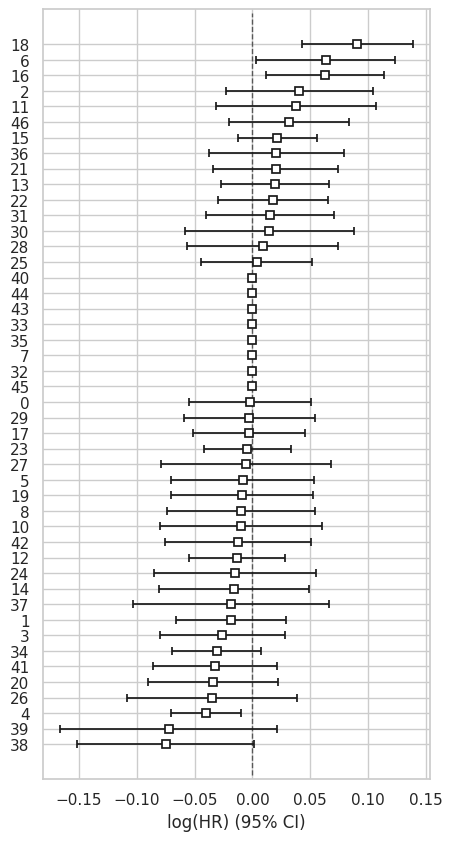

In [79]:
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(5, 10))
cph.plot()

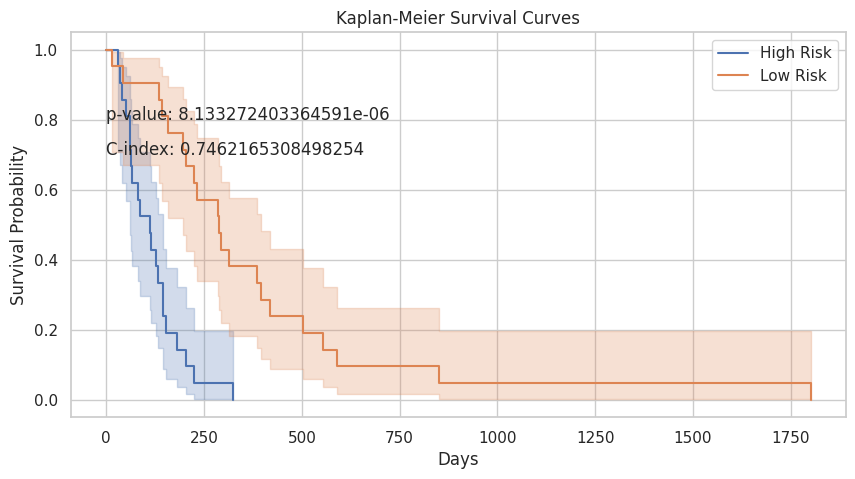

In [91]:
# kaplan mier plots
from lifelines import KaplanMeierFitter
kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()
plt.figure(figsize=(10, 5))

clr_df['partial_risk'] = cph.predict_partial_hazard(clr_df[leiden_cols])
clr_df['high_risk'] = clr_df['partial_risk'] > clr_df['partial_risk'].median()
kmf_high.fit(durations=clr_df['os_days'][clr_df['high_risk']], event_observed=clr_df['os_status'][clr_df['high_risk']], label='High Risk')
kmf_low.fit(durations=clr_df['os_days'][~clr_df['high_risk']], event_observed=clr_df['os_status'][~clr_df['high_risk']], label='Low Risk')

kmf_high.plot_survival_function()
kmf_low.plot_survival_function()
# add p-value and c-index
from lifelines.statistics import logrank_test
results = logrank_test(clr_df['os_days'][clr_df['high_risk']], clr_df['os_days'][~clr_df['high_risk']], clr_df['os_status'][clr_df['high_risk']], clr_df['os_status'][~clr_df['high_risk']])
plt.text(0.1, 0.8, f'p-value: {results.p_value}')
plt.text(0.1, 0.7, f'C-index: {cph.concordance_index_}')
plt.title('Kaplan-Meier Survival Curves')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend()

In [ ]:
main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
import sys
sys.path.append(main_path)
dataset = 'acmeso'
from models.clustering.data_processing import *
from data_manipulation.data import Data
from skimage.transform import resize
import torch

h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete.h5'.format(main_path, dataset, dataset)
frame, dims, rest = representations_to_frame(h5_complete_path, meta_field='Meso_type', rep_key='z_latent')

data = Data(dataset=dataset, marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path=main_path, load=True)
data_dicts = dict()

data_dicts['train'] = data.training.images
data_dicts['valid'] = data.validation.images
data_dicts['test']  = data.test.images

# Get tile information.
def get_x_y(tile_info):
    if '.' in str(tile_info):
        string = tile_info.split('.')[0]
    else:
        string = str(tile_info)
    x, y   = string.split('_')
    return int(x),int(y)
    
def get_wsi_arrays(frame, slide, matching_field, img_size, downsample, img_dicts):
    slide_indices  = frame[frame[matching_field]==slide].indexes.values.tolist()
    slide_tiles    = frame[frame[matching_field]==slide].tiles.values.tolist()
    slide_sets     = frame[frame[matching_field]==slide].original_set.values.tolist()
    # clr_plt = sns.color_palette("coolwarm", as_cmap=True)

    # color_map = clr_plt(attention_scores)

    y,x = get_x_y(slide_tiles[0])
    x_min = x
    x_max = x
    y_min = y
    y_max = y
    for i in slide_tiles:
        y_i, x_i  = get_x_y(i)
        x_min = min(x_min, x_i)
        y_min = min(y_min, y_i)
        x_max = max(x_max, x_i)
        y_max = max(y_max, y_i)
    x_max += 1
    y_max += 1

    wsi_x = int(x_max*img_size//downsample)
    wsi_y = int(y_max*img_size//downsample)

    # Original 5x.
    wsi   = np.ones((wsi_x, wsi_y, 3), dtype=np.uint8)*255
    # wsi_c = np.ones((wsi_x, wsi_y, 3), dtype=np.uint8)*255
    print('\t\tWhole Slide Image Resolution %s: (%s, %s)' % (slide, wsi_x, wsi_y))

    for index, tile, original_set in zip(slide_indices, slide_tiles, slide_sets):
        y_i, x_i  = get_x_y(tile)
        x_i *= img_size//downsample
        y_i *= img_size//downsample
        tile_img = img_dicts[original_set][int(index)]
        tile_img = np.array(resize(tile_img, (tile_img.shape[0]//downsample, tile_img.shape[1]//downsample), anti_aliasing=True), dtype=float)
        tile_img = (tile_img*255).astype(np.uint8)  

        
        mask  = np.ones((img_size//downsample,img_size//downsample))

        wsi[x_i:x_i+(img_size//downsample), y_i:y_i+(img_size//downsample), :]   = tile_img
        # wsi_c[x_i:x_i+(img_size//downsample), y_i:y_i+(img_size//downsample), :] = apply_mask(tile_img, mask, color, alpha=0.5)

    return wsi



Loading representations: /mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/acmeso/h224_w224_n3_zdim128/hdf5_acmeso_he_complete.h5
Keys: <KeysViewHDF5 ['hist_subtype', 'img_h_latent', 'img_z_latent', 'indexes', 'labels', 'original_set', 'patterns', 'samples', 'slides', 'tiles']>
acmeso
/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/datasets/acmeso/he/patches_h224_w224/hdf5_acmeso_he_train.h5


		Whole Slide Image Resolution 17HSOO575Y_(_)B_1,_SP18: (672, 582)


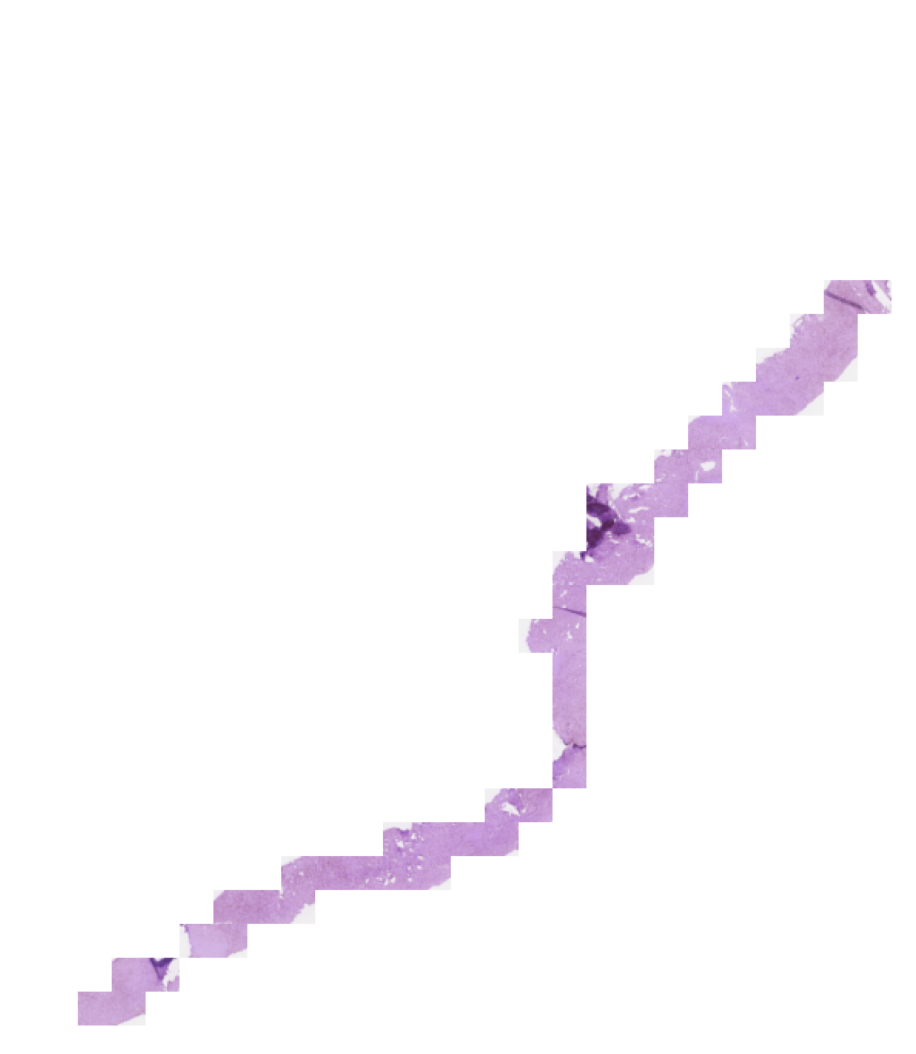

In [15]:
# ['H.21.026035_A1_AG_1,_17_01695_02_1', '17HSOO575Y_(_)B_1,_SP18_06734_B1_1', 'D.16.0012075.H_A1_1,_D.17.001_7546W_1', 'MP1631395_A1_1,_D.16.0084623.B_1', 'MP1709047_A1_1,_D.17.0024858X_A1_1', 'D.17.0090392.X_A1_1,_D.17.0029069.B_A1_1','LH18_-19647_A1_1,_MP-1723405_A1_1_MP', 'D.18.0077688.L_A1_1,_SP18-15315_A2_1', '16_40778D_1,_D.17.0058471.C_A1_1' ]
case_Id = '17HSOO575Y_(_)B_1,_SP18_06734_B1_1'[:23]
matching_field = 'slides'

wsi = get_wsi_arrays(frame, case_Id, matching_field, img_size=224, downsample=10, img_dicts=data_dicts)

for num, wsi_ in enumerate([wsi]):
    dpi = 50
    height, width, _ = wsi_.shape
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(1, 1, 1) 
    ax.imshow(wsi_/255.)
    ax.axis('off')
    plt.show(fig)
    plt.close(fig)


In [12]:
frame[frame['slides'] == case_Id].sort_values(by='tiles')

,0,1,2,3,4,5,6,7,8,9,...,126,127,hist_subtype,indexes,labels,original_set,patterns,samples,slides,tiles
171,0.557032,-1.465321,2.050453,0.815075,-1.183535,-2.155979,-1.792887,1.504424,-0.471233,-0.849826,...,-3.335034,0.775402,train,171,-1.0,train,train,"16_40778D_1,_D","16_40778D_1,_D.17.00584",10_11.jpeg
6266,0.510044,-1.770093,2.136101,0.933739,-0.887375,-2.303587,-1.918610,1.613374,-0.257036,-1.256255,...,-3.193079,0.231946,train,6266,-1.0,train,train,"16_40778D_1,_D","16_40778D_1,_D.17.00584",10_12.jpeg
7902,-1.192566,-1.357701,1.521897,1.331091,0.852139,-0.519094,-1.192219,1.322154,0.805799,-0.631429,...,-0.133268,-0.667846,train,7902,-1.0,train,train,"16_40778D_1,_D","16_40778D_1,_D.17.00584",10_18.jpeg
9200,-0.690819,-0.639707,1.104942,-0.193257,0.514626,-1.007458,-1.162116,0.720176,0.404538,-0.394699,...,-1.111952,-0.028513,train,9200,-1.0,train,train,"16_40778D_1,_D","16_40778D_1,_D.17.00584",10_19.jpeg
3208,-1.013142,-1.970551,1.478547,2.320973,0.016287,-0.118910,-1.009440,0.329301,-0.101295,0.605517,...,0.221517,0.135927,train,3208,-1.0,train,train,"16_40778D_1,_D","16_40778D_1,_D.17.00584",10_20.jpeg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10400,-0.420271,-2.226207,1.772532,2.325202,-1.067360,-1.122314,-1.183357,0.749918,-0.935463,0.187316,...,-1.509411,0.728226,train,10400,-1.0,train,train,"16_40778D_1,_D","16_40778D_1,_D.17.00584",9_21.jpeg
10443,-0.007990,-1.116731,1.784890,-0.409858,-1.388079,-0.006049,-1.635868,-1.261506,0.398127,-0.397466,...,-0.583734,0.550468,train,10443,-1.0,train,train,"16_40778D_1,_D","16_40778D_1,_D.17.00584",9_28.jpeg
11350,-0.169197,-0.802043,0.675124,2.241149,-0.649412,2.839113,-2.007070,-1.600825,1.740432,-2.292544,...,2.585984,-3.133153,train,11350,-1.0,train,train,"16_40778D_1,_D","16_40778D_1,_D.17.00584",9_30.jpeg
4201,-0.066431,-1.200340,1.267677,0.633872,-0.307797,-0.217574,-1.169616,-0.116413,0.755873,-0.377638,...,-0.609780,-0.143948,train,4201,-1.0,train,train,"16_40778D_1,_D","16_40778D_1,_D.17.00584",9_31.jpeg


In [8]:
from aicsimageio import AICSImage
image = '/nfs/home/users/fshahi/Projects/Datasets/acmeso/LH18_-19647_A1_1,_MP-1723405_A1_1_MP.svs'
img = AICSImage(image, dask_tiles=True)

In [ ]:
pixel_size = 1.8  # in microns
tile_size = 224  # in pixels

lazy_t0 = img.get_image_dask_data("YXS")  
img_array = lazy_t0.compute()
img_x = img_array.shape[0]
img_y = img_array.shape[1]
mpp = img.physical_pixel_sizes[1]
# mpp = 0.4415
scale = pixel_size / mpp
print(f'Physical Pixel Size: {mpp}')
print(f'Requested Pixel Size: {pixel_size}')
print(f'Scale: {scale}')
print(f'Scaled Tile: {int(np.round(tile_size * scale))}')

In [74]:
from PIL import Image
import numpy as np
background = 90  # percentage of background pixels to consider a tile as background
tile_apth = '/nfs/home/users/fshahi/Projects/Datasets/acmeso/tiled_test/17_19022_A_1_files/5.0/2_32.jpeg'
tile = np.array(Image.open(tile_apth))
jpeg = Image.fromarray(tile, mode='RGB').resize((tile_size,tile_size))
# plt.imshow(jpeg)

gray = jpeg.convert('L')
bw = gray.point(lambda x: 0 if x < 170 else 1)
# bw = gray.point(lambda p: p >150 and 255)
# bw.show()
bkg = np.average(bw)
print(f'Background Percentage: {bkg * 100:.2f}%')
if bkg <= (background / 100):
    display(jpeg)
    # jpeg.save(savetile_path, quality=90)

Background Percentage: 96.36%


In [53]:
bkg

83.85991310586735

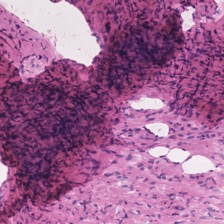

In [35]:
jpeg

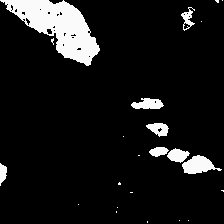

In [52]:
gray.point(lambda p: p>220 and 250)

In [15]:
lazy_t0

dask.array<transpose, shape=(62596, 83664, 3), dtype=uint8, chunksize=(240, 240, 3), chunktype=numpy.ndarray>

In [12]:
img.dims

<Dimensions [T: 1, C: 1, Z: 1, Y: 62596, X: 83664, S: 3]>

In [6]:
# show the image
print(temp_img.data.shape)

import matplotlib.pyplot as plt
plt.imshow(temp_img)

KeyboardInterrupt: 